In [1]:
!pip install -q --no-index --find-links=/kaggle/input/sennet-wheels/angionet-wheel angionet

In [2]:
from pathlib import Path

import albumentations as A
import albumentations.pytorch as AP
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm

from angionet.core import predict
from angionet.datasets import InferenceDataset
from angionet.functional import combine_patches, decode, encode, extract_patches
from angionet.postprocessing import postprocess

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class config:
    root = "/kaggle/input/blood-vessel-segmentation"
    model = "/kaggle/input/sennet-training/tu-resnet50d-best.pt"
    dim = 800
    stride = 600
    padding = 'reflect'
    batch_size = 4
    thresholds = (0.2, 0.5)
    transforms = A.Compose([
        AP.ToTensorV2(),
     ])
    
    submission = False
    
# Disable scientific notation
np.set_printoptions(suppress=True)

In [4]:
if config.submission:
    paths = Path(config.root).glob("test/**/*.tif")
else:
    paths = Path(config.root).glob("train/kidney_2/images/*.tif")
    
data = []
for path in paths:
    id_ = path.parent.parent.name + "_" + path.stem
    data.append((id_, str(path)))
    
df = pd.DataFrame(data, columns = ['id', 'path'])
df['group'] = df['id'].apply(lambda x: "_".join(x.split("_")[:-1]))
df['image_id'] = df['id'].apply(lambda x: x.split('_')[-1])
df = df.sort_values(['group', 'image_id'])

if not config.submission:
    rles = pd.read_csv('/kaggle/input/blood-vessel-segmentation/train_rles.csv')
    df = df.merge(rles, on = 'id', how = 'left')

df.head()

,id,path,group,image_id,rle
0,kidney_2_0000,/kaggle/input/blood-vessel-segmentation/train/...,kidney_2,0000,1 0
1,kidney_2_0001,/kaggle/input/blood-vessel-segmentation/train/...,kidney_2,0001,1 0
2,kidney_2_0002,/kaggle/input/blood-vessel-segmentation/train/...,kidney_2,0002,1 0
3,kidney_2_0003,/kaggle/input/blood-vessel-segmentation/train/...,kidney_2,0003,1 0
4,kidney_2_0004,/kaggle/input/blood-vessel-segmentation/train/...,kidney_2,0004,1 0


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(config.model, map_location = device)

if config.submission:
    frame = df.copy()
else:
    frame = df.sample(100)

output = predict(
    model = model, 
    frame = frame, 
    transforms = config.transforms, 
    device = device,
    config = config
)

Processing kidney_2: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


In [6]:
def visualize(paths, encodings, N=8):
    color = np.array([255, 10, 60], dtype="uint8")
    indices = np.random.permutation(np.arange(len(paths)))[:N]
    output = []
    for path, rle in zip(paths[indices], encodings[indices]):
        img = cv2.imread(path)
        mask = decode(rle, img.shape[:2])

        img = cv2.resize(img, (512, 512))
        mask = cv2.resize(mask, (512, 512))

        masked_img = np.where(mask[..., None], color, img)
        out = cv2.addWeighted(img, 0.8, masked_img, 0.2, 0)
        output.append(torch.from_numpy(out).permute(2, 0, 1))

    grid = make_grid(output, nrow=4).permute(1, 2, 0)
    fig = plt.figure(figsize=(20, 12))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

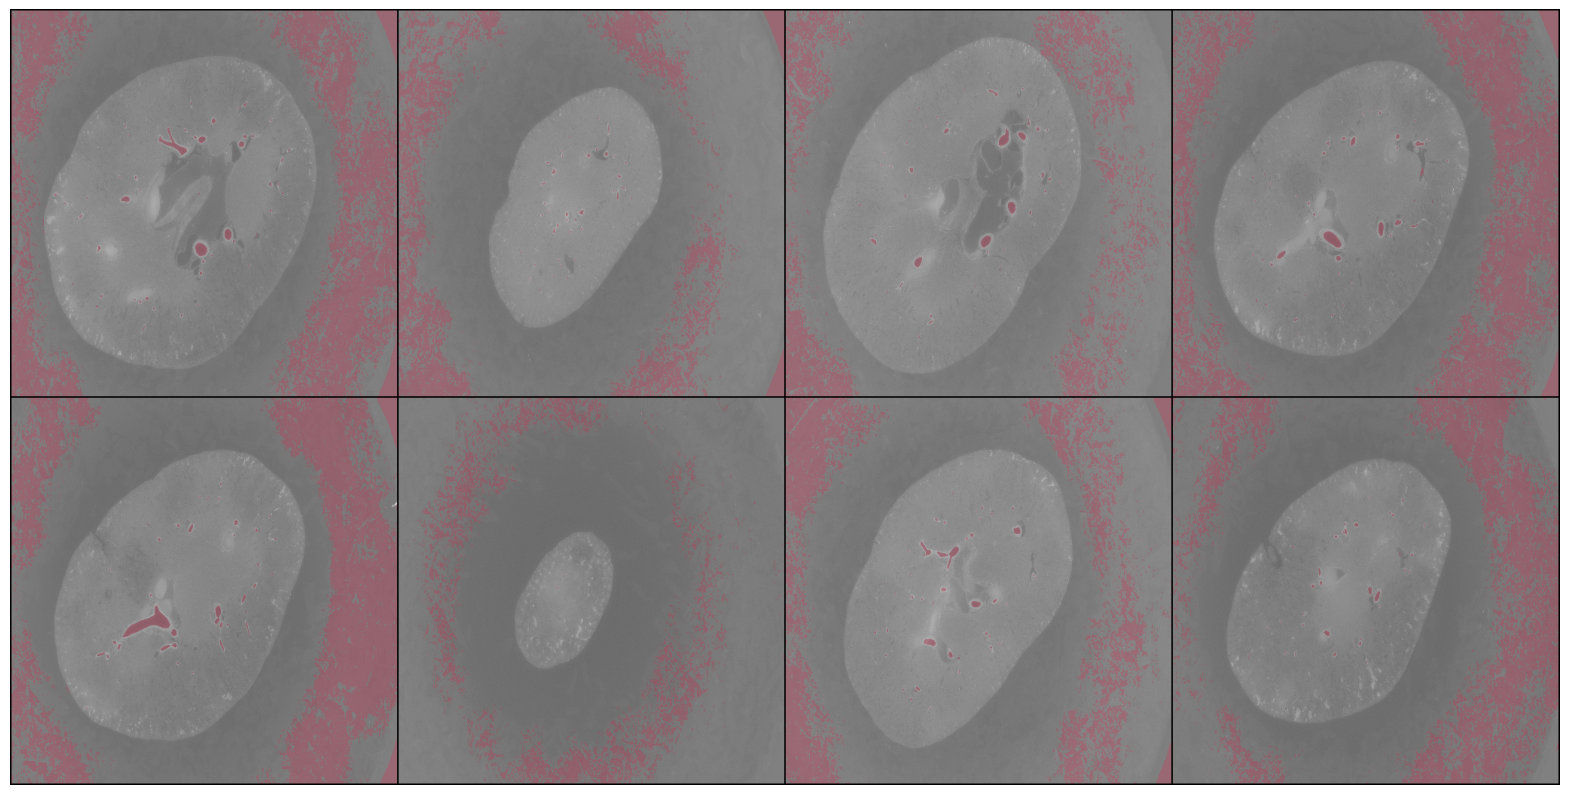

In [7]:
visualize(frame.path.values, np.asarray(output))

In [8]:
# if not config.submission:
#     from angionet.metrics import dice, confusion_matrix
    
#     labels, masks = [], []

#     for index, encoding in enumerate(output):
#         img = cv2.imread(frame.path.values[index], cv2.IMREAD_GRAYSCALE)

#         masks.append(decode(encoding, img.shape))
#         labels.append(decode(frame.rle.values[index], img.shape))

#     masks = np.asarray(np.stack(masks) / 255, dtype = np.uint8)
#     labels = np.asarray(np.stack(labels) / 255, dtype = np.uint8)
    
#     print(
#         dice(masks, labels),
#         confusion_matrix(masks, labels),
#         sep = '\n'
#     )

In [9]:
submission = pd.DataFrame({
    "id": frame.id.values,
    "rle": output
})

submission

,id,rle
0,kidney_2_0280,9 5 23 17 41 4 62 9 76 6 90 7 98 3 112 8 173 1...
1,kidney_2_0755,1 17 19 31 51 14 67 24 102 9 115 4 124 12 143 ...
2,kidney_2_1657,51 3 60 22 92 15 108 4 120 15 142 6 149 37 192...
3,kidney_2_0957,1 9 33 5 41 1 47 1 51 2 54 2 61 23 86 53 155 5...
4,kidney_2_0035,94 4 335 3 361 7 492 13 507 1 562 5 570 8 609 ...
...,...,...
95,kidney_2_1192,1 71 77 50 133 5 140 16 166 10 194 12 220 2 22...
96,kidney_2_0149,297 5 306 2 309 1 312 10 324 6 335 7 347 4 356...
97,kidney_2_1660,1 5 11 2 32 9 52 2 58 3 67 5 76 1 78 4 88 13 1...
98,kidney_2_2122,364 6 376 3 389 6 433 5 485 8 502 5 509 7 542 ...


In [10]:
submission.to_csv("submission.csv", index = False)